Given the same ligand, can you do arithmetic 
(protein-ligand complex embedding) - (protein embedding) + (new protein embedding) = (new protein-ligand complex embedding) ?

In [13]:
import os
import sys

# Get the current notebook's directory
current_directory = os.getcwd()

# Get the parent directory
parent_directory = os.path.dirname(os.path.dirname(current_directory))

# Add the parent directory to the module search path
sys.path.insert(0, parent_directory)
print(parent_directory)
import pickle
from collections import Counter

/n/holylabs/LABS/mzitnik_lab/Users/afang/GET


In [9]:
with open("/n/holystore01/LABS/mzitnik_lab/Lab/afang/frequency_splits_torsion_09_2024/PL_nonredund_test.pkl", "rb") as f:
    test_data = pickle.load(f)

In [10]:
ligands = [item['id'].split("_")[-2] for item in test_data]

In [11]:
ligand_counts = Counter(ligands)
ligand_counts

Counter({'CLA': 1532,
         'kmer': 653,
         'ADP': 553,
         'ATP': 415,
         'FAD': 304,
         'NAD': 256,
         'SAH': 200,
         'FMN': 200,
         'SF4': 189,
         'HEM': 169,
         'NAP': 155,
         'SO4': 152,
         'PO4': 149,
         'NDP': 147,
         'GOL': 135,
         'PLP': 120,
         'GTP': 117,
         'GDP': 109,
         'CHL': 107,
         'SIA': 106,
         'PQN': 105,
         'CAP': 105,
         'CLR': 104,
         'PEB': 102,
         'SAM': 101,
         'Y01': 101,
         'ANP': 98,
         'BCL': 98,
         'TPP': 96,
         'HEC': 94,
         'GSH': 93,
         'A86': 81,
         'AGS': 76,
         '8CT': 71,
         'AMP': 67,
         'CL': 66,
         'FES': 65,
         'COA': 65,
         'UDP': 63,
         'UNK': 63,
         'CYC': 63,
         'NAI': 61,
         'MAN': 59,
         'AF3': 58,
         'ARG': 56,
         '1': 55,
         'CPL': 52,
         'GLC': 51,
         'TRP':

In [14]:
from data.converter.pdb_to_list_blocks import pdb_to_list_blocks
from data.converter.sm_pdb_to_blocks import sm_pdb_to_blocks
import data.dataset
from data.atom3d_dataset import LBADataset
import models
import torch
from trainers.abs_trainer import Trainer
import importlib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from models import DenoisePretrainModel, AffinityPredictor
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import itertools
import random
import scipy
from torch_scatter import scatter_sum

In [26]:
import importlib
importlib.reload(data.dataset)
from data.dataset import VOCAB
from data.dataset import blocks_interface, blocks_to_data
from data.dataset import BlockGeoAffDataset, PDBBindBenchmark, DynamicBatchWrapper
from models import PredictionModel

Pretrained model

In [27]:
pretrain_ckpt = "/n/holyscratch01/mzitnik_lab/afang/GET/pretrain/models/InteractNN-torsion/version_116/checkpoint/epoch28_step295801.ckpt"
model = PredictionModel.load_from_pretrained(pretrain_ckpt)

/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__in

Pretrained model params: hidden_size=32,
               edge_size=32, k_neighbors=8, 
               n_layers=4, bottom_global_message_passing=False,
               global_message_passing=True, 
               fragmentation_method=PS_300


In [18]:
dataset = PDBBindBenchmark("/n/holystore01/LABS/mzitnik_lab/Lab/afang/frequency_splits_torsion_09_2024/PL_nonredund_test.pkl")

In [19]:
dataset_ids = [d['id'] for d in dataset.indexes]
len(set(dataset_ids)) == len(dataset_ids)        

True

In [20]:
ligands = [x['id'].split("_")[4] for x in dataset.indexes]
from collections import Counter
ligand_counter = Counter(ligands)
ligand_counter

Counter({'CLA': 1532,
         'kmer': 708,
         'ADP': 553,
         'ATP': 415,
         'FAD': 304,
         'NAD': 256,
         'SAH': 200,
         'FMN': 200,
         'SF4': 189,
         'HEM': 169,
         'NAP': 155,
         'SO4': 152,
         'PO4': 149,
         'NDP': 147,
         'GOL': 135,
         'PLP': 120,
         'GTP': 117,
         'GDP': 109,
         'CHL': 107,
         'SIA': 106,
         'PQN': 105,
         'CAP': 105,
         'CLR': 104,
         'PEB': 102,
         'SAM': 101,
         'Y01': 101,
         'ANP': 98,
         'BCL': 98,
         'TPP': 96,
         'HEC': 94,
         'GSH': 93,
         'A86': 81,
         'AGS': 76,
         '8CT': 71,
         'AMP': 67,
         'CL': 66,
         'FES': 65,
         'COA': 65,
         'UDP': 63,
         'UNK': 63,
         'CYC': 63,
         'NAI': 61,
         'MAN': 59,
         'AF3': 58,
         'ARG': 56,
         'CPL': 52,
         'GLC': 51,
         'TRP': 50,
         'BGC

In [94]:
ligand_id = 'ADP'
for dataset_id in dataset_ids:
    if dataset_id.split("_")[4] == ligand_id:
        print(dataset_id)

3vkg_3.pdb_3vkg_3_ADP_K.pdb
5sup_2.pdb_5sup_2_ADP_M.pdb
4bn2_3.pdb_4bn2_3_ADP_H.pdb
7wrg_1.pdb_7wrg_1_ADP_C.pdb
3vkg_2.pdb_3vkg_2_ADP_D.pdb
1va6_1.pdb_1va6_1_ADP_H.pdb
4xe8_1.pdb_4xe8_1_ADP_C.pdb
8juv_1.pdb_8juv_1_ADP_B.pdb
4gt8_1.pdb_4gt8_1_ADP_B.pdb
7wrg_2.pdb_7wrg_2_ADP_E.pdb
3tpt_2.pdb_3tpt_2_ADP_F.pdb
4d86_1.pdb_4d86_1_ADP_C.pdb
5i0h_1.pdb_5i0h_1_ADP_C.pdb
6gng_2.pdb_6gng_2_ADP_F.pdb
2r65_3.pdb_2r65_3_ADP_H.pdb
1gm5_1.pdb_1gm5_1_ADP_E.pdb
8qyr_1.pdb_8qyr_1_ADP_H.pdb
1l8t_1.pdb_1l8t_1_ADP_D.pdb
5g40_1.pdb_5g40_1_ADP_C.pdb
4kxf_8.pdb_4kxf_8_ADP_R.pdb
5gsz_1.pdb_5gsz_1_ADP_B.pdb
5e7p_1.pdb_5e7p_1_ADP_C.pdb
6mfv_1.pdb_6mfv_1_ADP_E.pdb
7wak_1.pdb_7wak_1_ADP_B.pdb
4kxf_5.pdb_4kxf_5_ADP_N.pdb
1f48_1.pdb_1f48_1_ADP_Q.pdb
1f48_1.pdb_1f48_1_ADP_R.pdb
3tlx_1.pdb_3tlx_1_ADP_H.pdb
2b9j_1.pdb_2b9j_1_ADP_D.pdb
3gbj_1.pdb_3gbj_1_ADP_D.pdb
5hr5_1.pdb_5hr5_1_ADP_E.pdb
3viu_1.pdb_3viu_1_ADP_B.pdb
3ouz_2.pdb_3ouz_2_ADP_H.pdb
2vos_1.pdb_2vos_1_ADP_B.pdb
7ti7_1.pdb_7ti7_1_ADP_B.pdb
4n67_1.pdb_4n67_1_AD

## Protein Ligand case study
For proteins bound to the same ligand

In [96]:
chosen_ligand = "ADP"
protein_dataset = []
proteins = []
for idx, d in enumerate(dataset):
    if dataset.indexes[idx]["id"].split("_")[4] != chosen_ligand:
        continue
    protein_dataset.append(d)
    proteins.append(dataset.indexes[idx]["id"])
len(proteins)

553

In [97]:
embeddings = {}
batch_size = 8
model = model.to("cuda")
for i in tqdm(range(0, len(protein_dataset), batch_size)):
    model.eval()
    end_idx = min(i+batch_size, len(protein_dataset))
    with torch.no_grad():
        if type(dataset) == LBADataset:
            minibatch = LBADataset.collate_fn(protein_dataset[i:end_idx])
            pdb_ids = [d["id"] for d in protein_dataset[i:end_idx]]
        else:
            minibatch = PDBBindBenchmark.collate_fn(protein_dataset[i:end_idx])
            pdb_ids = proteins[i:i+batch_size]
        minibatch = Trainer.to_device(minibatch, "cuda")
        output = model.infer(minibatch)
        batch_id = torch.zeros_like(minibatch["segment_ids"])  # [Nb]
        batch_id[torch.cumsum(minibatch["lengths"], dim=0)[:-1]] = 1
        batch_id.cumsum_(dim=0)  # [Nb], item idx in the batch
        for idx, pdb_id in enumerate(pdb_ids):
            embeddings[pdb_id] = output.graph_repr[idx].cpu().numpy()

100%|██████████| 70/70 [00:26<00:00,  2.68it/s]


In [31]:
embeddings_all = {}
batch_size = 8
for i in tqdm(range(0, len(dataset), batch_size)):
    model.eval()
    end_idx = min(i+batch_size, len(dataset))
    with torch.no_grad():
        if type(dataset) == LBADataset:
            minibatch = LBADataset.collate_fn([dataset[x] for x in range(i, end_idx)])
            pdb_ids = [d["id"] for d in dataset[i:end_idx]]
        else:
            minibatch = PDBBindBenchmark.collate_fn([dataset[x] for x in range(i, end_idx)])
            pdb_ids = dataset_ids[i:end_idx]
        minibatch = Trainer.to_device(minibatch, "cuda")
        output = model.infer(minibatch)
        batch_id = torch.zeros_like(minibatch["segment_ids"])  # [Nb]
        batch_id[torch.cumsum(minibatch["lengths"], dim=0)[:-1]] = 1
        batch_id.cumsum_(dim=0)  # [Nb], item idx in the batch
        for idx, pdb_id in enumerate(pdb_ids):
            embeddings_all[pdb_id] = output.graph_repr[idx].cpu().numpy()

100%|██████████| 1388/1388 [08:32<00:00,  2.71it/s]


In [98]:
pocket_only_embeddings = {}

for i in tqdm(range(0, len(protein_dataset), batch_size)):
    model.eval()
    end_idx = min(i+batch_size, len(protein_dataset))
    with torch.no_grad():
        minibatch_ = [BlockGeoAffDataset.filter_for_segment(d, 0) for d in protein_dataset[i:end_idx]]
        if type(dataset) == LBADataset:
            minibatch = LBADataset.collate_fn(minibatch_)
            pdb_ids = [d["id"] for d in protein_dataset[i:end_idx]]
        else:
            minibatch = PDBBindBenchmark.collate_fn(minibatch_)
            pdb_ids = proteins[i:i+batch_size]
        minibatch = Trainer.to_device(minibatch, "cuda")
        output = model.infer(minibatch)
        for idx, pdb_id in enumerate(pdb_ids):
            pocket_only_embeddings[pdb_id] = output.graph_repr[idx].cpu().numpy()

100%|██████████| 70/70 [00:13<00:00,  5.06it/s]


In [99]:
pairs = list(itertools.combinations(pocket_only_embeddings.keys(), 2))
pairs = random.sample(pairs, 1000)
len(pocket_only_embeddings), len(pairs)

(553, 1000)

In [100]:
from sklearn.metrics.pairwise import cosine_similarity

dist_construct = []
dist_rand = []
cmplx_dist = []

valid_embeddings_all = [x for x in dataset_ids if x.split("_")[4] != chosen_ligand]
embeddings_exclude_ligand = {x: embeddings_all[x] for x in valid_embeddings_all}

for p1, p2 in pairs:
    p1_cmplx = embeddings[p1]
    p2_cmplx = embeddings[p2]
    p1_prot = pocket_only_embeddings[p1]
    p2_prot = pocket_only_embeddings[p2]

    p1_cmplx_construct = p2_cmplx - p2_prot + p1_prot
    p2_cmplx_construct = p1_cmplx - p1_prot + p2_prot
    
    rand_p1_cmplx = random.choice(list(embeddings_exclude_ligand.values()))
    rand_p2_cmplx = random.choice(list(embeddings_exclude_ligand.values()))

    # rand_p1_cmplx = np.mean(list(embeddings.values()), axis=0)
    # rand_p2_cmplx = np.mean(list(embeddings.values()), axis=0)
    dist_construct.append(cosine_similarity(p1_cmplx_construct.reshape(1, -1), p1_cmplx.reshape(1, -1))[0][0])
    dist_construct.append(cosine_similarity(p2_cmplx_construct.reshape(1, -1), p2_cmplx.reshape(1, -1))[0][0])
    dist_rand.append(cosine_similarity(p1_cmplx.reshape(1, -1), rand_p1_cmplx.reshape(1, -1))[0][0])
    dist_rand.append(cosine_similarity(p2_cmplx.reshape(1, -1), rand_p2_cmplx.reshape(1, -1))[0][0])
    cmplx_dist.append(cosine_similarity(p1_cmplx.reshape(1, -1), p2_cmplx.reshape(1, -1))[0][0])
    cmplx_dist.append(cosine_similarity(p1_cmplx.reshape(1, -1), p2_cmplx.reshape(1, -1))[0][0])

    # dist_construct.append(np.linalg.norm(p1_cmplx_construct - p1_cmplx))
    # dist_construct.append(np.linalg.norm(p2_cmplx_construct - p2_cmplx))
    # dist_rand.append(np.linalg.norm(p1_cmplx - rand_p1_cmplx))
    # dist_rand.append(np.linalg.norm(p2_cmplx - rand_p2_cmplx))
    # cmplx_dist.append(np.linalg.norm(p1_cmplx - p2_cmplx))
    # cmplx_dist.append(np.linalg.norm(p1_cmplx - p2_cmplx))


2000
0.5545 3.9986946061239677e-283


/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


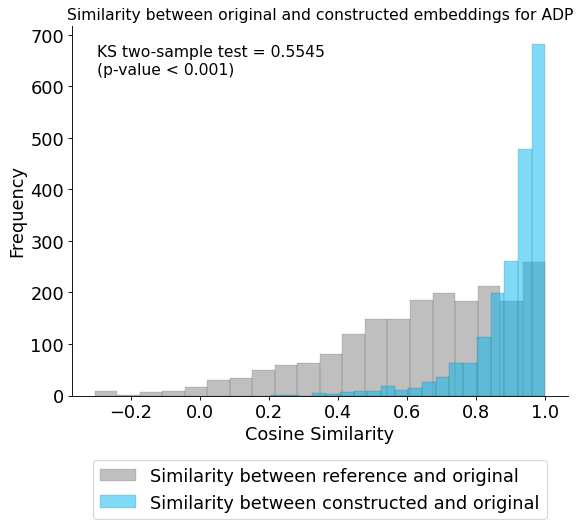

In [101]:
import seaborn as sns

print(len(dist_construct))
plt.figure(figsize=(8, 6), dpi=80)
plt.rcParams.update({'font.size': 16})
ax = sns.histplot(dist_rand, bins=20, alpha=0.5, color="#808080", label="Similarity between reference and original")
ax = sns.histplot(dist_construct, bins=20, alpha=0.5, color="#00b7f0", label="Similarity between constructed and original")
plt.ylabel("Frequency")
plt.xlabel("Cosine Similarity")
plt.setp(ax.patches, linewidth=0.1)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=False, ncol=1)
ks_stat, ks_p = scipy.stats.ks_2samp(dist_construct, dist_rand)
print(ks_stat, ks_p)
textstr = f"KS two-sample test = {ks_stat} \n(p-value < {ks_p+0.001:.3f})"
plt.text(x=0.05, y=0.95, s=textstr, transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', fontdict={'family': 'sans-serif'})
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title(f"Similarity between original and constructed embeddings for {chosen_ligand}", fontsize=14)
plt.savefig(f"similarity_construct_{chosen_ligand}.png", bbox_inches='tight', dpi=300)
plt.show()

Baseline is distance of protein-ligand complex to any protein-ligand complex (does not have to be of the same ligand)

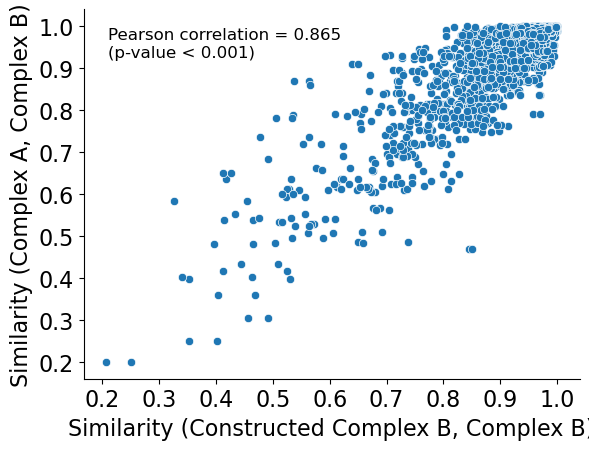

In [102]:
df = {"dist_construct": dist_construct, "dist_rand": dist_rand, "cmplx_dist": cmplx_dist}
ax = sns.scatterplot(df, x="dist_construct", y="cmplx_dist")
plt.rcParams.update({'font.size': 12})
plt.xlabel("Similarity (Constructed Complex B, Complex B)")
plt.ylabel("Similarity (Complex A, Complex B)")
pearsonr, pval = scipy.stats.pearsonr(df["dist_construct"], df["cmplx_dist"]).statistic, scipy.stats.pearsonr(df["dist_construct"], df["cmplx_dist"]).pvalue
textstr = f"Pearson correlation = {pearsonr:.3f} \n(p-value < {pval+0.001:.3f})"
plt.text(x=0.05, y=0.95, s=textstr, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', fontdict={'family': 'sans-serif'})
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(f"coorelation_construct_{chosen_ligand}.png", bbox_inches='tight', dpi=300)
plt.show()

This does hold, but it is just because if the original complexes have very similar graph embeddings then the compositional relationship holds.

If the original complexes have very different graph embeddings, then the compositional relationship does not hold.

## Protein Ligand and Nucleotide Ligand Case Study
What about for a protein bound to a ligand and a nucleotide bound to the same ligand?
i.e. does (protein-ligand complex embedding) - (protein embedding) + (nucleotide embedding) = (nucleotide-ligand complex embedding) ? 

In [42]:
dataset_pion = PDBBindBenchmark("/n/holystore01/LABS/mzitnik_lab/Lab/afang/frequency_splits_torsion_09_2024/Pion_nonredund_test.pkl")
dataset_pl = PDBBindBenchmark("/n/holystore01/LABS/mzitnik_lab/Lab/afang/frequency_splits_torsion_09_2024/PL_nonredund_test.pkl")
dataset_nl = PDBBindBenchmark("/n/holystore01/LABS/mzitnik_lab/Lab/afang/frequency_splits_torsion_09_2024/RNAL_nonredund_test.pkl")

In [53]:
dataset_pion_ligands = [x['id'].split("_")[4] for x in dataset_pion.indexes]
dataset_pl_ligands = [x['id'].split("_")[4] for x in dataset_pl.indexes]
dataset_nl_ligands = [x['id'].split("_")[-2] for x in dataset_nl.indexes]

ligand_counter_pion = Counter(dataset_pion_ligands)
ligand_counter_pl = Counter(dataset_pl_ligands)
ligand_counter_nl = Counter(dataset_nl_ligands)

In [59]:
pion_nl_keys = set(ligand_counter_pion.keys()).intersection(set(ligand_counter_nl.keys()))
for key in pion_nl_keys:
    print(key, ligand_counter_pion[key], ligand_counter_nl[key])

MG 2004 279
NA 6 40
K 99 81
CA 1767 30


In [58]:
pl_nl_keys = set(ligand_counter_pl.keys()).intersection(set(ligand_counter_nl.keys()))
for key in pl_nl_keys:
    print(key, ligand_counter_pl[key], ligand_counter_nl[key])

5GP 18 1
ARG 56 2
OIY 2 1
C2E 16 1
2BA 1 2


In [60]:
select_ligand = 'MG'

In [62]:
filtered_dataset_nl = []
nl_pdbs = []
for idx, d in enumerate(dataset_nl.indexes):
    if d["id"].split("_")[-2] == select_ligand:
        filtered_dataset_nl.append(dataset_nl[idx])
        nl_pdbs.append(d["id"])
len(filtered_dataset_nl)

279

In [84]:
filtered_dataset_pion = []
pion_pdbs = []
for idx, d in enumerate(dataset_pion.indexes):
    if d["id"].split("_")[4] == select_ligand:
        pion_pdbs.append(d["id"])
        filtered_dataset_pion.append(dataset_pion[idx])
len(filtered_dataset_pion)

2004

In [83]:
embeddings_pion_all = {}
batch_size = 8
for i in tqdm(range(0, len(dataset_pion), batch_size)):
    model.eval()
    end_idx = min(i+batch_size, len(dataset_pion))
    with torch.no_grad():
        if type(dataset_pion) == LBADataset:
            minibatch = LBADataset.collate_fn([dataset_pion[x] for x in range(i, end_idx)])
            pdb_ids = [d["id"] for d in dataset_pion[i:end_idx]]
        else:
            minibatch = PDBBindBenchmark.collate_fn([dataset_pion[x] for x in range(i, end_idx)])
            pdb_ids = dataset_ids[i:end_idx]
        minibatch = Trainer.to_device(minibatch, "cuda")
        output = model.infer(minibatch)
        batch_id = torch.zeros_like(minibatch["segment_ids"])  # [Nb]
        batch_id[torch.cumsum(minibatch["lengths"], dim=0)[:-1]] = 1
        batch_id.cumsum_(dim=0)  # [Nb], item idx in the batch
        for idx, pdb_id in enumerate(pdb_ids):
            embeddings_all[pdb_id] = output.graph_repr[idx].cpu().numpy()

100%|██████████| 900/900 [01:21<00:00, 11.03it/s]


In [81]:
embeddings_pion = {}
batch_size = 8
for i in range(0, len(filtered_dataset_pion), batch_size):
    model.eval()
    with torch.no_grad():
        minibatch = LBADataset.collate_fn(filtered_dataset_pion[i:i+batch_size])
        pdb_ids = pion_pdbs[i:i+batch_size]
        minibatch = Trainer.to_device(minibatch, "cuda")
        output = model.infer(minibatch)
        batch_id = torch.zeros_like(minibatch["segment_ids"])  # [Nb]
        batch_id[torch.cumsum(minibatch["lengths"], dim=0)[:-1]] = 1
        batch_id.cumsum_(dim=0)  # [Nb], item idx in the batch
        for idx, pdb_id in enumerate(pdb_ids):
            embeddings_pion[pdb_id] = output.graph_repr[idx].cpu().numpy()

In [82]:
embeddings_p = {}
batch_size = 8
for i in range(0, len(filtered_dataset_pion), batch_size):
    model.eval()
    with torch.no_grad():
        minibatch_ = [BlockGeoAffDataset.filter_for_segment(d, 0) for d in filtered_dataset_pion[i:i+batch_size]]
        minibatch = LBADataset.collate_fn(minibatch_)
        pdb_ids = pion_pdbs[i:i+batch_size]
        minibatch = Trainer.to_device(minibatch, "cuda")
        output = model.infer(minibatch)
        batch_id = torch.zeros_like(minibatch["segment_ids"])  # [Nb]
        batch_id[torch.cumsum(minibatch["lengths"], dim=0)[:-1]] = 1
        batch_id.cumsum_(dim=0)  # [Nb], item idx in the batch
        for idx, pdb_id in enumerate(pdb_ids):
            embeddings_p[pdb_id] = output.graph_repr[idx].cpu().numpy()

In [72]:
embeddings_nl = {}
for i in range(0, len(filtered_dataset_nl), batch_size):
    model.eval()
    with torch.no_grad():
        minibatch = BlockGeoAffDataset.collate_fn(filtered_dataset_nl[i:i+batch_size])
        pdb_ids = nl_pdbs[i:i+batch_size]
        minibatch = Trainer.to_device(minibatch, "cuda")
        output = model.infer(minibatch)
        batch_id = torch.zeros_like(minibatch["segment_ids"])  # [Nb]
        batch_id[torch.cumsum(minibatch["lengths"], dim=0)[:-1]] = 1
        batch_id.cumsum_(dim=0)  # [Nb], item idx in the batch
        for idx, pdb_id in enumerate(pdb_ids):
            embeddings_nl[pdb_id] = output.graph_repr[idx].cpu().numpy()

In [74]:
embeddings_nl_all = {}
for i in range(0, len(dataset_nl), batch_size):
    model.eval()
    with torch.no_grad():
        minibatch = BlockGeoAffDataset.collate_fn([dataset_nl[j] for j in range(i,i+batch_size)])
        pdb_ids = [d["id"] for d in dataset_nl.indexes[i:i+batch_size]]
        minibatch = Trainer.to_device(minibatch, "cuda")
        output = model.infer(minibatch)
        batch_id = torch.zeros_like(minibatch["segment_ids"])  # [Nb]
        batch_id[torch.cumsum(minibatch["lengths"], dim=0)[:-1]] = 1
        batch_id.cumsum_(dim=0)  # [Nb], item idx in the batch
        for idx, pdb_id in enumerate(pdb_ids):
            embeddings_nl_all[pdb_id] = output.graph_repr[idx].cpu().numpy()

In [76]:
embeddings_n = {}
for i in range(0, len(filtered_dataset_nl), batch_size):
    model.eval()
    with torch.no_grad():
        minibatch_ = [BlockGeoAffDataset.filter_for_segment(d, 0) for d in filtered_dataset_nl[i:i+batch_size]]
        minibatch = BlockGeoAffDataset.collate_fn(minibatch_)
        pdb_ids = nl_pdbs[i:i+batch_size]
        minibatch = Trainer.to_device(minibatch, "cuda")
        output = model.infer(minibatch)
        batch_id = torch.zeros_like(minibatch["segment_ids"])  # [Nb]
        batch_id[torch.cumsum(minibatch["lengths"], dim=0)[:-1]] = 1
        batch_id.cumsum_(dim=0)  # [Nb], item idx in the batch
        for idx, pdb_id in enumerate(pdb_ids):
            embeddings_n[pdb_id] = output.graph_repr[idx].cpu().numpy()

In [91]:
pion_constr_dist = []
nl_constr_dist = []
rand_dist = []
pairs = list(itertools.product(pion_pdbs, nl_pdbs))

other_nl_pdbs_embeddings = [embeddings_nl_all[x] for x in embeddings_nl_all.keys() if x not in nl_pdbs]

for pion_pdb, nl_pdb in pairs:
    pion_embedding = embeddings_pion[pion_pdb]
    nl_embedding = embeddings_nl[nl_pdb]

    pion_constr = embeddings_nl[nl_pdb] - embeddings_n[nl_pdb] + embeddings_p[pion_pdb]
    nl_constr = embeddings_pion[pion_pdb] - embeddings_p[pion_pdb] + embeddings_n[nl_pdb]

    nl_constr_dist.append(cosine_similarity(nl_constr.reshape(-1, 1), nl_embedding.reshape(-1, 1))[0][0])
    rand_dist.append(cosine_similarity(random.choice(other_nl_pdbs_embeddings).reshape(-1, 1), nl_embedding.reshape(-1, 1))[0][0])


In [93]:
len(nl_constr_dist)

559116

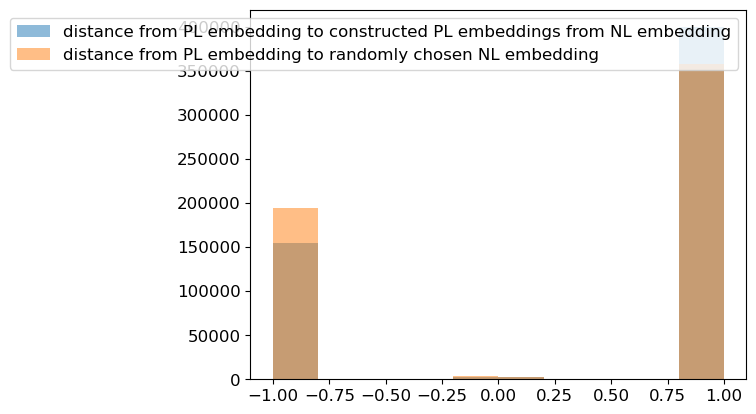

In [92]:
plt.hist(nl_constr_dist, alpha=0.5, label = "distance from PL embedding to constructed PL embeddings from NL embedding")
# plt.hist(rand_dist1, label = "distance from PL embedding to random embeddings")
plt.hist(rand_dist, alpha=0.5, label = "distance from PL embedding to randomly chosen NL embedding")
plt.legend()
plt.show()

## What does this show us?
For the same ligand if it interacts similarly to the pocket, the compositional relationship holds. If it interacts differently, the compositional relationship does not hold.

### Most distant PL and NLs
('5kva', '2ydh') for this PL and NL which are most distant, SAM interacts with the protein and nucleotide differently. 
* In 5kva, SAM interacts with the protein has a sulfur-sulfur bridge with a MET residue.
* In 2ydh, this is not present as this nucleotides do not have any sulfurs.

('4ymg', '2ydh') for this PL and NL which is second most distant: 4ymg and 2ydh have a separate set of intermolecular interactions that they engage in, though both are hydrogen bonds, it is different parts or amounts that engage in the hydrogen bonds.

### Closest PL and NLs
('6bm5', '4oqu') and (2uyq, some NL) are quite close to NLs because they do not engage in sulfur-sulfur interactions.

## What can we use this model for then?
Test similarity of interfaces? Similarity of interaction of ligands with different proteins?

Cluster PPI interfaces? for different mechanisms of interaction?

Are there useful zero shot tasks where similarity of interaction is important?